In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rca import RCA
from rca import utils

np.random.seed(1331)

Define a plotting function for visual inspection:

In [2]:
def plot_func(im, wind=False, cmap='gist_stern', title=''):
    if not wind:
        plt.imshow(im, cmap=cmap, interpolation='Nearest')
    else:
        vmin, vmax = wind
        plt.imshow(im, cmap=cmap, interpolation='Nearest', vmin=vmin, vmax=vmax)
    if title:
        plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()

# Load and prepare data

Load star catalog; `stars.npy` contains 323 stars from one of the two ACS chips in exposure `jb5d20b7_drz_1`, and `pos.npy` their respective (image) positions.

In [3]:
starcat = np.load('stars.npy')
pos = np.load('pos.npy')
print(starcat.shape, pos.shape)

(323, 41, 41) (323, 2)


Stars are fresh from `SExtractor` so we need to pass on the masks to RCA; for visual inspection, we also replace them with 0's in the data.

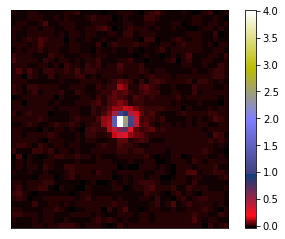

170


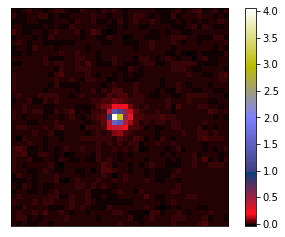

230


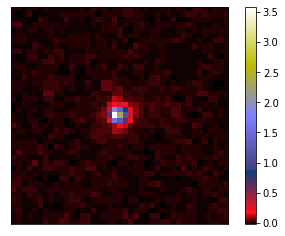

9


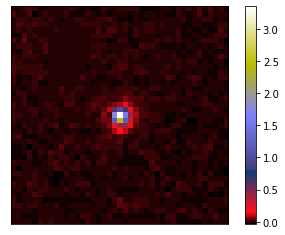

271


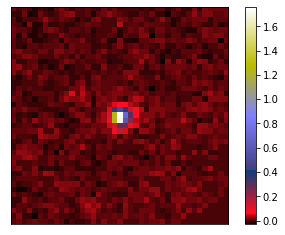

33


In [4]:
mask = np.ones(starcat.shape)
mask[starcat<-1e10] = 0
starcat[starcat<-1e10] = 0
for j in np.random.choice(starcat.shape[0], 5, False):
    plot_func(starcat[j])
    print(j)

Split them into "train" and "test" stars - the latter won't be used to fit the model:

In [5]:
test_idx = np.random.choice(starcat.shape[0], 23, False)
train_idx = list(set(range(starcat.shape[0])) - set(test_idx))

train_stars, train_pos = starcat[train_idx], pos[train_idx]
test_stars, test_pos = starcat[test_idx], pos[test_idx]
train_mask = mask[train_idx]

# Run RCA

Remember RCA expects the stars (and pixel weights) to be in $(p\times p\times n_\rm{stars})$ format, so convert them (and their masks):

In [6]:
train_stars = utils.rca_format(train_stars)
train_mask = utils.rca_format(train_mask)

## No super-resolution

We need to provide a very crude first guess of the PSF size (only used for centroid, and thus intrapixel shift, estimation). HST ACS has a pixel scale of about 0.049'', and an FWHM of around 0.9'', or about 2 pixels, so let us provide RCA's `fit` method with `psf_size=2` (FWHM is the default convention).

Run without superresolution first:

In [7]:
n_comp = 4
rca_fitter = RCA(n_comp, verbose=True)

S, A = rca_fitter.fit(train_stars, train_pos, train_mask, psf_size=2.)
rca_fitter.quicksave('fitted_model')

Running basic initialization tasks...
... Done.
Constructing graph constraint...
 > power max =  3.1459960292017133
 > selected e: 0.24414252273932888	selected a: 1.99	 chosen index: 4/5
 > selected e: 0.8763968319757999	selected a: 0.34085425326699187	 chosen index: 4/5
 > selected e: 1.6604640777206927	selected a: 0.03242322717402432	 chosen index: 3/5
 > selected e: 1.6604640777206927	selected a: 0.34085425326699187	 chosen index: 1/5
... Done.


/Users/tliaudat/Documents/PhD/codes/venv_p3/venv_p3/lib/python3.7/site-packages/rca-2.0-py3.7.egg/rca/utils.py:393: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.VT = np.vstack((eigenvect for eigenvect in list_eigenvects))
/Users/tliaudat/Documents/PhD/codes/venv_p3/venv_p3/lib/python3.7/site-packages/modopt/base/types.py:137: FutureWarning: Conversion of the second argument of issubdtype from `'float'` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype('float').type`.
  (not np.issubdtype(val.dtype, dtype))):
100% (200 of 200) |######################| Elapsed Time: 0:01:10 Time:  0:01:10
100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (200 of 200) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


Look at learned eigenPSFs:

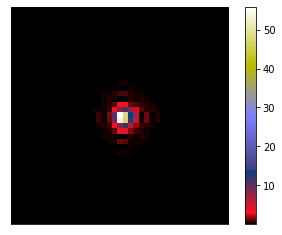

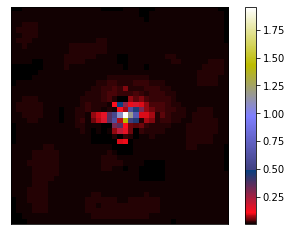

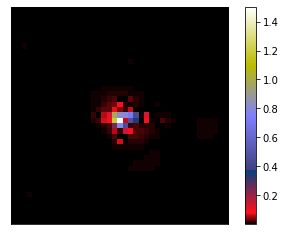

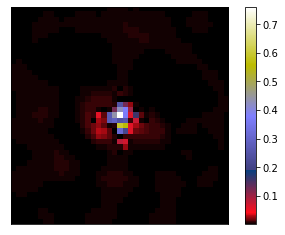

In [8]:
eigenPSFs = utils.reg_format(S)
for epsf in eigenPSFs:
    plot_func(np.abs(epsf))

To compare with test stars, we need to match their shifts and fluxes, which can be done with RCA's `validation_star` method:

In [9]:
reconstructed_stars = rca_fitter.validation_stars(utils.rca_format(test_stars), test_pos)

Look at a few examples:

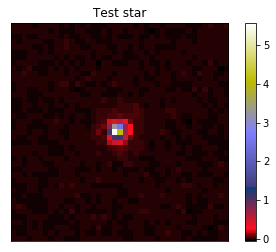

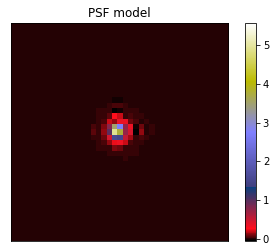

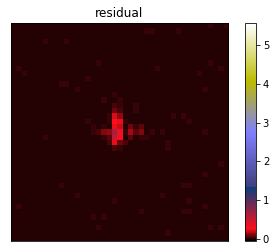

10


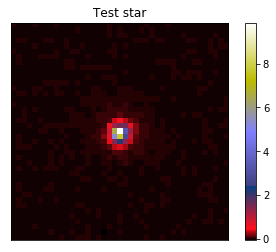

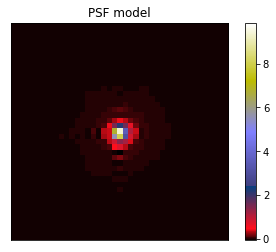

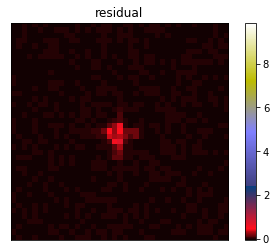

2


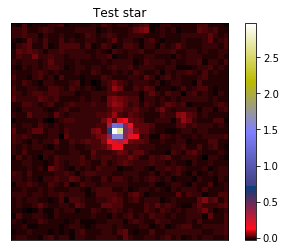

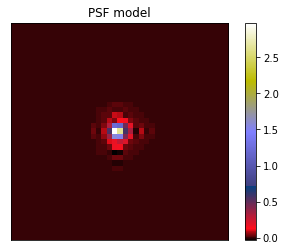

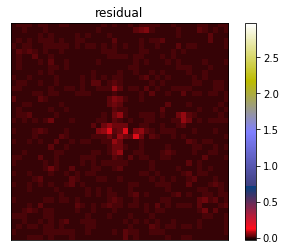

15


In [10]:
for j in np.random.choice(test_stars.shape[0], 3, False):
    rec_star = reconstructed_stars[j]
    wind = (min(np.min(test_stars[j]),np.min(rec_star)),
            max(np.max(test_stars[j]),np.max(rec_star)))
    plot_func(test_stars[j], title='Test star', wind=wind)
    plot_func(rec_star, title='PSF model', wind=wind)
    plot_func(np.abs(test_stars[j]-rec_star), title='residual', wind=wind)
    print(j)

And compute average normalized Mean Square Error:

In [11]:
MSE = np.mean((np.linalg.norm(test_stars - reconstructed_stars, axis=(1,2)) /
              np.linalg.norm(test_stars, axis=(1,2))**2))
print(MSE)

0.02745083873063987


## Super-resolution

Rerun RCA, but oversample PSF model:

Running basic initialization tasks...
... Done.
Constructing graph constraint...
 > power max =  3.1459960292017133
 > selected e: 0.24414252273932888	selected a: 1.99	 chosen index: 4/5
 > selected e: 0.8763968319757999	selected a: 0.34085425326699187	 chosen index: 4/5
 > selected e: 1.6604640777206927	selected a: 0.03242322717402432	 chosen index: 3/5
 > selected e: 1.6604640777206927	selected a: 0.34085425326699187	 chosen index: 1/5
... Done.


/Users/tliaudat/Documents/PhD/codes/venv_p3/venv_p3/lib/python3.7/site-packages/rca-2.0-py3.7.egg/rca/utils.py:393: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.VT = np.vstack((eigenvect for eigenvect in list_eigenvects))
/Users/tliaudat/Documents/PhD/codes/venv_p3/venv_p3/lib/python3.7/site-packages/modopt/base/types.py:137: FutureWarning: Conversion of the second argument of issubdtype from `'float'` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype('float').type`.
  (not np.issubdtype(val.dtype, dtype))):
100% (200 of 200) |######################| Elapsed Time: 0:02:20 Time:  0:02:20
100% (400 of 400) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (200 of 200) |######################| Elapsed Time: 0:02:19 Time:  0:02:19


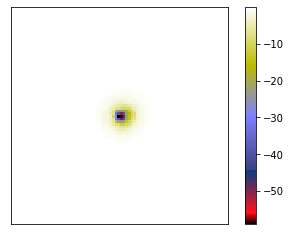

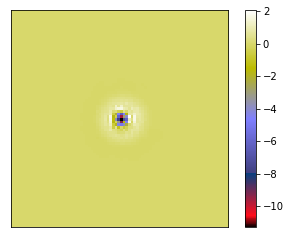

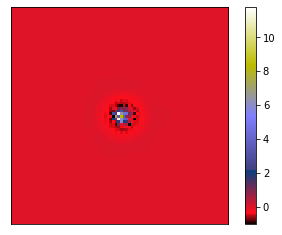

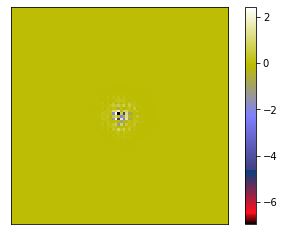

In [12]:
rca_sr = RCA(n_comp, upfact=2, verbose=True)

sr_S, sr_A = rca_sr.fit(train_stars, train_pos, train_mask, psf_size=2.)

rca_sr.quicksave('sr_fitted_model')

sr_eigenPSFs = utils.reg_format(sr_S)
for epsf in sr_eigenPSFs:
    plot_func(epsf)

Look at both the finely sampled PSF model (obtained from RCA's `estimate_psf` method) and its degraded version for direct comparison with our test stars:

(23, 82, 82)
(23, 41, 41)


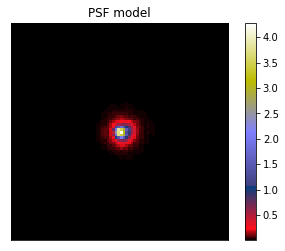

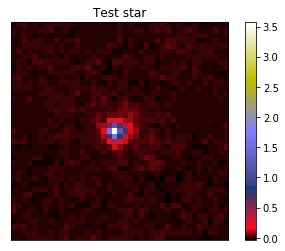

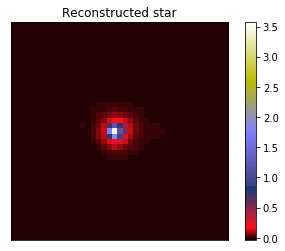

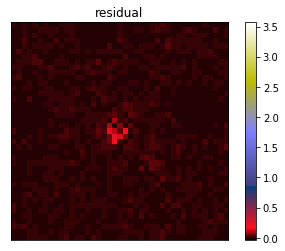

5


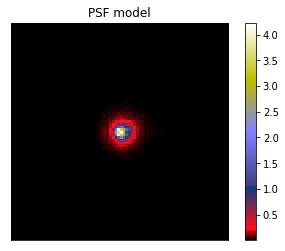

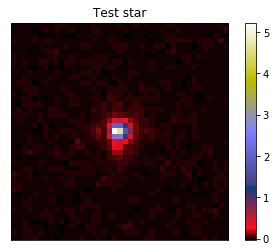

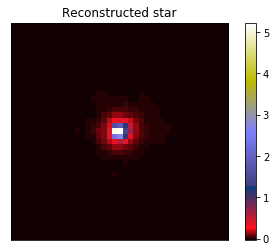

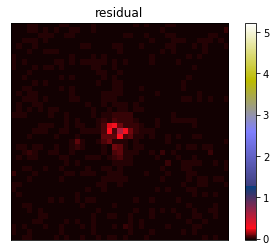

17


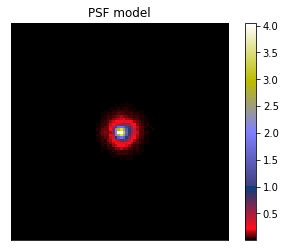

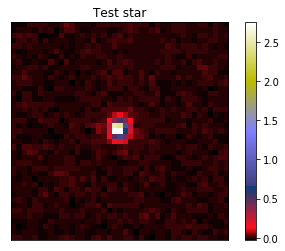

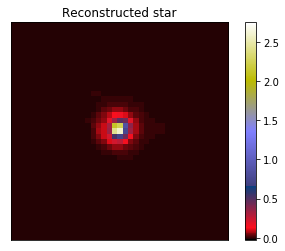

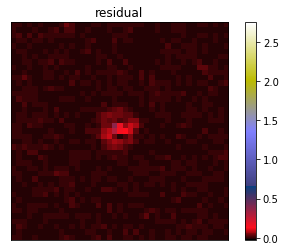

21


In [13]:
PSFs = rca_sr.estimate_psf(test_pos)
sr_reconstructed_stars = rca_sr.validation_stars(utils.rca_format(test_stars), test_pos)

print(PSFs.shape)
print(sr_reconstructed_stars.shape)

for j in np.random.choice(test_stars.shape[0], 3, False):
    rec_star = sr_reconstructed_stars[j]
    wind = (min(np.min(test_stars[j]),np.min(rec_star)),
            max(np.max(test_stars[j]),np.max(rec_star)))
    plot_func(PSFs[j], title='PSF model')
    plot_func(test_stars[j], title='Test star', wind=wind)
    plot_func(rec_star, title='Reconstructed star', wind=wind)
    plot_func(np.abs(test_stars[j]-rec_star), title='residual', wind=wind)
    print(j)

In [14]:
MSE = np.mean((np.linalg.norm(test_stars - sr_reconstructed_stars, axis=(1,2)) /
              np.linalg.norm(test_stars, axis=(1,2))**2))
print(MSE)

0.030229573379189478
